# Machine Learning (COSC2673)


## Assignment 2: Machine Learning Project
## Project 1 - Classify Images of Colon Cancer


### Arya Baddam - (s4054024)


### Vaibhav Jain - (s3950267)


#### Group 95

Problem Statement:

Our goal is to develop a machine learning system that can classify histopathology images of colon cells based on whether the cell is **cancerous** (`isCancerous`) and to find out what **cell type** it belongs to: `epithelial`, `fibroblast`, `inflammatory`, or `others`

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from PIL import Image
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
# This code loads both of the label files
main_data = pd.read_csv("Image_classification_data/data_labels_mainData.csv")
extra_data = pd.read_csv("Image_classification_data/data_labels_extraData.csv")

In [25]:
main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [26]:
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


In [27]:
IMAGE_DIR = "Image_classification_data/patch_images/"

### Exploratory Data Analysis

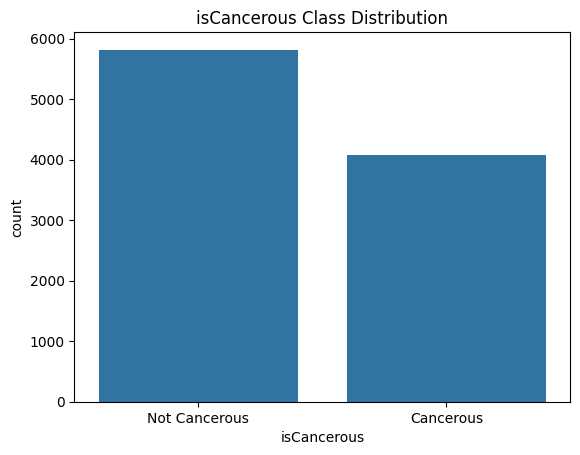

In [28]:
# Visualising class imbalance
sns.countplot(data=main_data, x='isCancerous')
plt.title("isCancerous Class Distribution")
plt.xticks([0, 1], ["Not Cancerous", "Cancerous"])
plt.show()

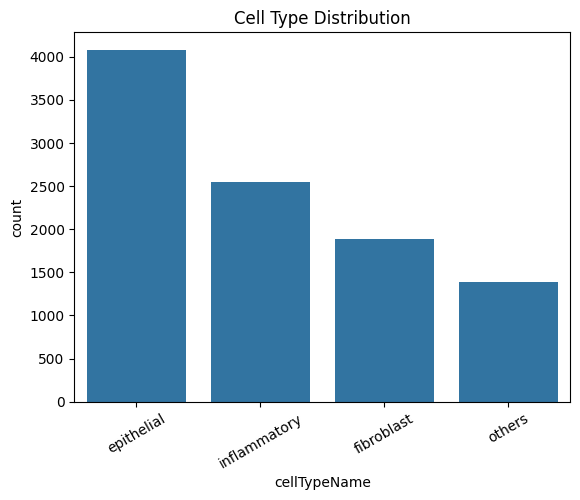

In [29]:
sns.countplot(data=main_data, x='cellTypeName', order=main_data['cellTypeName'].value_counts().index)
plt.title("Cell Type Distribution")
plt.xticks(rotation=30)
plt.show()

In [30]:
cancer_counts = main_data['isCancerous'].value_counts(normalize=True) * 100
print(cancer_counts)

isCancerous
0    58.781326
1    41.218674
Name: proportion, dtype: float64


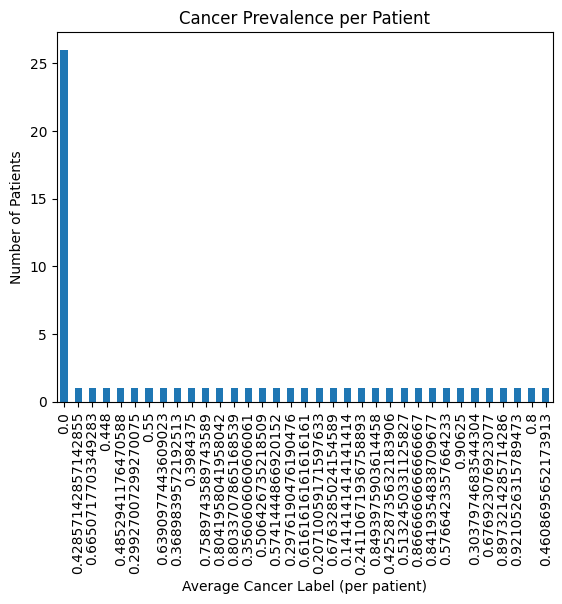

In [31]:
patient_counts = main_data.groupby('patientID')['isCancerous'].mean().value_counts()
patient_counts.plot(kind='bar')
plt.title("Cancer Prevalence per Patient")
plt.xlabel("Average Cancer Label (per patient)")
plt.ylabel("Number of Patients")
plt.show()

### Image Loader

In [13]:
def load_images(df, label_col, image_col='ImageName', image_dir=IMAGE_DIR):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(image_dir, row[image_col])
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB').resize((27, 27))
            X.append(np.array(img).flatten())
            y.append(row[label_col])
    return np.array(X), np.array(y)

### Binary Classification - isCancerous

In [14]:
X_cancer, y_cancer = load_images(main_data, label_col='isCancerous')
image_names = main_data['ImageName'].values

In [15]:
# Train/Test split
X_train_c, X_test_c, y_train_c, y_test_c, name_train, name_test = train_test_split(
    X_cancer, y_cancer, image_names, test_size=0.2, stratify=y_cancer, random_state=42)

In [16]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_c, y_train_c)
y_pred_c = rf_model.predict(X_test_c)

Random Forest - Binary Classification (isCancerous)
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1164
           1       0.87      0.82      0.85       816

    accuracy                           0.88      1980
   macro avg       0.88      0.87      0.87      1980
weighted avg       0.88      0.88      0.88      1980



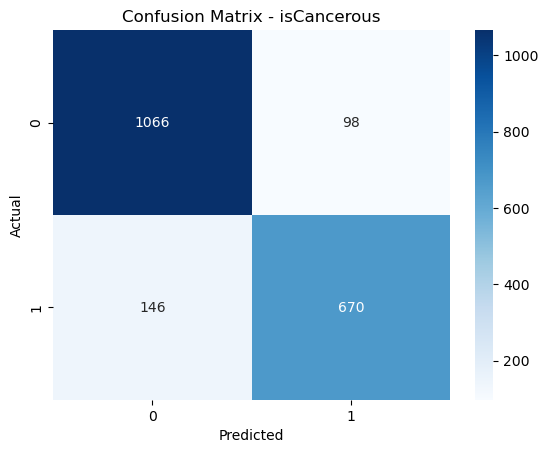

In [17]:
# Evaluation
print("Random Forest - Binary Classification (isCancerous)")
print(classification_report(y_test_c, y_pred_c))
sns.heatmap(confusion_matrix(y_test_c, y_pred_c), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - isCancerous")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Multi-Class Classification - cellTypeName

In [18]:
X_type, y_type = load_images(main_data, label_col='cellTypeName')
le = LabelEncoder()
y_type_encoded = le.fit_transform(y_type)
image_names_type = main_data['ImageName'].values

In [19]:
X_train_t, X_test_t, y_train_t, y_test_t, name_train_t, name_test_t = train_test_split(
    X_type, y_type_encoded, image_names_type, test_size=0.2, stratify=y_type_encoded, random_state=42)

In [20]:
rf_type = RandomForestClassifier(n_estimators=100, random_state=42)
rf_type.fit(X_train_t, y_train_t)
y_pred_t = rf_type.predict(X_test_t)

Random Forest - Multiclass Classification of (cellTypeName)
              precision    recall  f1-score   support

  epithelial       0.76      0.92      0.84       816
  fibroblast       0.64      0.58      0.61       378
inflammatory       0.63      0.78      0.69       509
      others       0.79      0.08      0.14       277

    accuracy                           0.70      1980
   macro avg       0.70      0.59      0.57      1980
weighted avg       0.71      0.70      0.66      1980



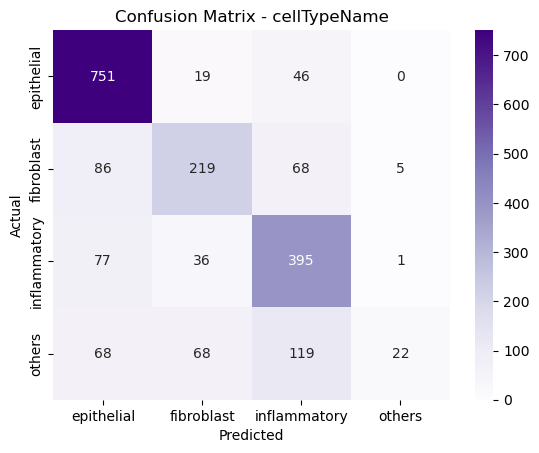

In [27]:
print("Random Forest - Multiclass Classification of (cellTypeName)")
print(classification_report(y_test_t, y_pred_t, target_names=le.classes_))
sns.heatmap(confusion_matrix(y_test_t, y_pred_t), annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - cellTypeName")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Boosted Model Evaluation using data_labels_extraData.csv

In [31]:
combined_df = pd.concat([main_data[['ImageName', 'isCancerous']], extra_data[['ImageName', 'isCancerous']]])
X_boost, y_boost = load_images(combined_df, label_col='isCancerous')

In [32]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_boost, y_boost, test_size=0.2, stratify=y_boost, random_state=42)
boosted_model = RandomForestClassifier(n_estimators=100, random_state=42)
boosted_model.fit(X_train_b, y_train_b)
y_pred_b = boosted_model.predict(X_test_b)

Boosted Model Evaluation (with data_labels_extraData.csv)
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      2642
           1       0.85      0.73      0.78      1414

    accuracy                           0.86      4056
   macro avg       0.86      0.83      0.84      4056
weighted avg       0.86      0.86      0.86      4056



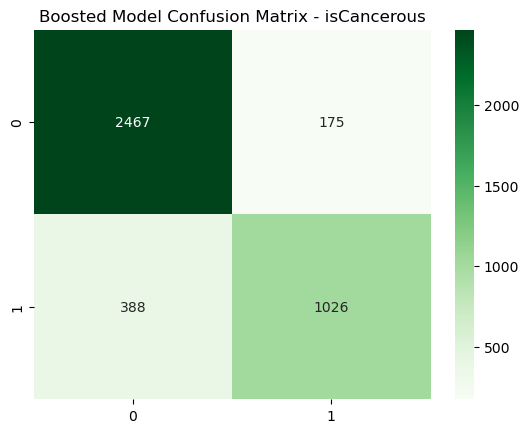

In [33]:
print("Boosted Model Evaluation (with data_labels_extraData.csv)")
print(classification_report(y_test_b, y_pred_b))
sns.heatmap(confusion_matrix(y_test_b, y_pred_b), annot=True, fmt='d', cmap='Greens')
plt.title("Boosted Model Confusion Matrix - isCancerous")
plt.show()

### Data Preprocessing and PCA

In [35]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_c)
X_test_std = scaler.transform(X_test_c)

In [36]:
normalizer = Normalizer()
X_train_norm = normalizer.fit_transform(X_train_c)
X_test_norm = normalizer.transform(X_test_c)

In [37]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)


In [38]:
print(f"PCA shape: {X_train_pca.shape}")

PCA shape: (7916, 50)


### Logistic Regression Baseline

In [39]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_std, y_train_c)
y_pred_log = log_model.predict(X_test_std)

In [40]:
print("Logistic Regression - isCancerous")
print(classification_report(y_test_c, y_pred_log))

Logistic Regression - isCancerous
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1164
           1       0.79      0.83      0.81       816

    accuracy                           0.84      1980
   macro avg       0.83      0.84      0.83      1980
weighted avg       0.84      0.84      0.84      1980



### Hyperparameter Tuning (RandomizedSearchCV)

In [41]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

In [43]:
rand_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [44]:
rand_search.fit(X_train_c, y_train_c)
print(f"Best Params: {rand_search.best_params_}")
print(f"Best F1 Score: {rand_search.best_score_:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  29.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=  43.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=  44.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=  44.3s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=50; total time=  13.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  28.8s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=50; total time=  13.8s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=  10.7s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=  10.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  28.3s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=50; total time=  13.9s
[CV] END .max_depth=10, min_samples_s

### Export Predictions to CSV

In [ ]:
# Binary
results_cancer = pd.DataFrame({
    "ImageName": name_test,
    "Actual_isCancerous": y_test_c,
    "Predicted_isCancerous": y_pred_c
})
results_cancer.to_csv("results_isCancerous.csv", index=False)

In [46]:
# Multiclass
actual_types = le.inverse_transform(y_test_t)
predicted_types = le.inverse_transform(y_pred_t)

In [47]:
results_type = pd.DataFrame({
    "ImageName": name_test_t,
    "Actual_cellTypeName": actual_types,
    "Predicted_cellTypeName": predicted_types
})
results_type.to_csv("results_cellTypeName.csv", index=False)

In [51]:
celltype = pd.read_csv("results_cellTypeName.csv")
celltype

,ImageName,Actual_cellTypeName,Predicted_cellTypeName
0,3075.png,epithelial,epithelial
1,8212.png,epithelial,epithelial
2,10037.png,others,epithelial
3,18369.png,inflammatory,inflammatory
4,71.png,inflammatory,inflammatory
...,...,...,...
1975,9476.png,epithelial,epithelial
1976,7785.png,fibroblast,fibroblast
1977,21182.png,inflammatory,inflammatory
1978,12006.png,fibroblast,inflammatory


In [53]:
is_cancer = pd.read_csv("results_isCancerous.csv")
is_cancer

,ImageName,Actual_isCancerous,Predicted_isCancerous
0,20195.png,0,0
1,9073.png,0,0
2,16942.png,0,0
3,11935.png,1,1
4,18591.png,0,0
...,...,...,...
1975,3115.png,1,1
1976,18880.png,0,0
1977,401.png,0,0
1978,8724.png,1,1


# Conclusion and other information